<a href="https://colab.research.google.com/github/codingpotato/pill-detection/blob/master/pill_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

## Clone Pill Detection

In [1]:
!git clone https://github.com/codingpotato/pill-detection.git

Cloning into 'pill-detection'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 66 (delta 33), reused 21 (delta 9), pack-reused 0
Unpacking objects: 100% (66/66), done.


## Environment Variables

In [0]:
import os

os.environ['ROOT_DIR'] = os.getcwd()
os.environ['IMAGE_DIR'] = os.path.join(os.environ['ROOT_DIR'], 'images')
os.environ['DATA_DIR'] = os.path.join(os.environ['ROOT_DIR'], 'data')
os.environ['TRAIN_DIR'] = os.path.join(os.environ['ROOT_DIR'], 'train')

os.environ['PILL_DETECTION_DIR'] = os.path.join(os.environ['ROOT_DIR'],
                                                'pill-detection')
os.environ['ORIGIN_IMAGE_DIR'] = os.path.join(os.environ['PILL_DETECTION_DIR'],
                                              'images')

In [0]:
!mkdir ${IMAGE_DIR}
!mkdir ${DATA_DIR}
!mkdir ${TRAIN_DIR}

## Download Pre-Trained Model

In [4]:
!wget http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz

--2018-11-18 06:33:08--  http://download.tensorflow.org/models/object_detection/ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.206.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51025348 (49M) [application/x-tar]
Saving to: ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’

ssdlite_mobilenet_v 100%[===================>]  48.66M  46.1MB/s    in 1.1s    

2018-11-18 06:33:09 (46.1 MB/s) - ‘ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz’ saved [51025348/51025348]



In [5]:
!tar xfv ssdlite_mobilenet_v2_coco_2018_05_09.tar.gz
!mv ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt* ${DATA_DIR}

ssdlite_mobilenet_v2_coco_2018_05_09/checkpoint
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.data-00000-of-00001
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.meta
ssdlite_mobilenet_v2_coco_2018_05_09/model.ckpt.index
ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/saved_model.pb
ssdlite_mobilenet_v2_coco_2018_05_09/pipeline.config
ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb
ssdlite_mobilenet_v2_coco_2018_05_09/
ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/variables/
ssdlite_mobilenet_v2_coco_2018_05_09/saved_model/


## Install Tensorflow Object Detection API

In [6]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 22623 (delta 0), reused 0 (delta 0), pack-reused 22621
Receiving objects: 100% (22623/22623), 562.73 MiB | 28.04 MiB/s, done.
Resolving deltas: 100% (13138/13138), done.
Checking out files: 100% (2836/2836), done.


In [7]:
!pip install Cython
!apt-get install protobuf-compiler
!git clone https://github.com/cocodataset/cocoapi.git
!cd cocoapi/PythonAPI; make; cp -r pycocotools ${ROOT_DIR}/models/research/

    100% |████████████████████████████████| 2.0MB 8.7MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libprotobuf10 libprotoc10
The following NEW packages will be installed:
  libprotobuf10 libprotoc10 protobuf-compiler
0 upgraded, 3 newly installed, 0 to remove and 5 not upgraded.
Need to get 1,242 kB of archives.
After this operation, 4,942 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf10 amd64 3.0.0-9.1ubuntu1 [651 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotoc10 amd64 3.0.0-9.1ubuntu1 [566 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 protobuf-compiler amd64 3.0.0-9.1ubuntu1 [24.5 kB]
Fetched 1,242 kB in 0s (10.6 MB/s)
Selecting previously unselected package libprotobuf10:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .

In [8]:
%env PYTHONPATH=/content/models/research:/content/models/research/slim
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

env: PYTHONPATH=/content/models/research:/content/models/research/slim
/content/models/research


## Test Tensorflow Object Detection API

In [9]:
!python object_detection/builders/model_builder_test.py

......................
----------------------------------------------------------------------
Ran 22 tests in 0.127s

OK


# Prepare Images

In [0]:
from PIL import Image
from random import randint

image_width = 300
image_height = 300

def generate_images(name):
  for index in xrange(1, 101):
    image = Image.new('RGB', (image_width, image_height), '#000')
    image_path = os.path.join(os.environ['ORIGIN_IMAGE_DIR'], name + '.png')
    pill_image = Image.open(image_path)
    rotated_image = pill_image.rotate(randint(0, 359), expand=True)
    x = randint(0, image_width - rotated_image.size[0])
    y = randint(0, image_height - rotated_image.size[1])
    image.paste(rotated_image, (x, y))
    save_path = os.path.join(os.environ['IMAGE_DIR'], 
                             name + '_' + str(index) + '.png')
    image.save(save_path)

In [0]:
files = os.listdir(os.environ['ORIGIN_IMAGE_DIR'])
labels = [os.path.splitext(f)[0] for f in files]

In [0]:
for label in labels:
  generate_images(label)

In [0]:
import cv2

def boundingRect(image):
  image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, image_bw = cv2.threshold(image_bw, 1, 255, cv2.THRESH_BINARY)
  _, contours, _ = cv2.findContours(image_bw,
                                    cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  max_area = 0
  x, y, w, h = 0, 0, 0, 0
  for cnt in contours:
    area = cv2.contourArea(cnt)
    if area > max_area:
      max_area = area
      x, y, w, h = cv2.boundingRect(cnt)
  return (x, y, w, h)

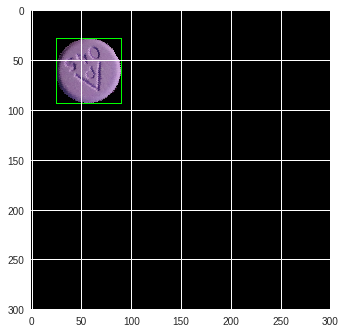

In [16]:
import matplotlib.pyplot as plt

image_path = os.path.join(os.environ['IMAGE_DIR'], labels[0] + '_1.png')
image = cv2.imread(image_path)
x, y, w, h = boundingRect(image)
cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
plt.imshow(image)

# Prepare Data

## Create Label Map

In [0]:
file_path = os.path.join(os.environ['DATA_DIR'], 'label_map.pbtxt')
with open(file_path, 'w') as f:
  index = 1
  for label in labels:
    f.write("item {\n  id: " + str(index) + "\n  name: '" + label + "'\n}\n\n")
    index += 1

## Generate TF Record

In [0]:
import tensorflow as tf
from object_detection.utils import dataset_util


def generate_tf_record(record_path, start, size):
  writer = tf.python_io.TFRecordWriter(record_path)
  label_index = 1
  for label in labels:
    for index in xrange(start, start + size):
      filename = os.path.join(os.environ['IMAGE_DIR'],
                              label + '_' + str(index) + '.png')
      image = cv2.imread(filename)
      x, y, w, h = boundingRect(image)
    
      image_format = b'png'
      with tf.gfile.GFile(filename, 'rb') as fid:
        encoded_png = fid.read()
      
      xmin = float(x) / image_width
      ymin = float(y) / image_height
      xmax = float(x + w - 1) / image_width
      ymax = float(y + h - 1) / image_height
      
      tf_example = tf.train.Example(features=tf.train.Features(feature={
          'image/height': dataset_util.int64_feature(image_width),
          'image/width': dataset_util.int64_feature(image_height),
          'image/filename': dataset_util.bytes_feature(filename),
          'image/source_id': dataset_util.bytes_feature(filename),
          'image/encoded': dataset_util.bytes_feature(encoded_png),
          'image/format': dataset_util.bytes_feature(image_format),
          'image/object/bbox/xmin': dataset_util.float_list_feature([xmin]),
          'image/object/bbox/xmax': dataset_util.float_list_feature([xmax]),
          'image/object/bbox/ymin': dataset_util.float_list_feature([ymin]),
          'image/object/bbox/ymax': dataset_util.float_list_feature([ymax]),
          'image/object/class/text': dataset_util.bytes_list_feature(
              [label]),
          'image/object/class/label': dataset_util.int64_list_feature(
              [label_index]),
      }))
      writer.write(tf_example.SerializeToString())
    label_index += 1
  writer.close()

In [0]:
train_record = os.path.join(os.environ['DATA_DIR'], 'train.record')
generate_tf_record(train_record, 1, 70)
test_record = os.path.join(os.environ['DATA_DIR'], 'test.record')
generate_tf_record(test_record, 71, 30)

## Create Config file

In [0]:
!cp object_detection/samples/configs/ssdlite_mobilenet_v2_coco.config ${DATA_DIR}
!sed -i "s|PATH_TO_BE_CONFIGURED|${DATA_DIR}|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config
!sed -i "s|mscoco_label_map.pbtxt|label_map.pbtxt|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config
!sed -i "s|mscoco_train.record-?????-of-00100|train.record|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config
!sed -i "s|mscoco_val.record-?????-of-00010|test.record|g" ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config

# Train

In [0]:
get_ipython().system_raw('python object_detection/model_main.py \
    --pipeline_config_path=${DATA_DIR}/ssdlite_mobilenet_v2_coco.config \
    --model_dir=${TRAIN_DIR} \
    --num_train_steps=50000 \
    --sample_1_of_n_eval_examples=1 \
    --alsologtostderr &')

# Download Model

In [117]:
!rm -r ${ROOT_DIR}/exported_graphs; mkdir ${ROOT_DIR}/exported_graphs
!python object_detection/export_inference_graph.py \
  --input_type image_tensor \
  --pipeline_config_path ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config \
  --trained_checkpoint_prefix ${TRAIN_DIR}/model.ckpt-18808 \
  --output_directory ${ROOT_DIR}/exported_graphs

rm: cannot remove '/content/exported_graphs': No such file or directory
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1118 14:06:17.966794 139890043742080 tf_logging.py:125] From /content/models/research/object_detection/exporter.py:328: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
W1118 14:06:17.973248 139890043742080 tf_logging.py:125] From /content/models/research/object_detection/exporter.py:482: print_model_analysis (from tensorflow.contrib.tfprof.model_analyzer) is deprecated and will be removed after 2018-01-01.
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. 

In [118]:
!zip -r exp_g.zip ${ROOT_DIR}/exported_graphs

  adding: content/exported_graphs/ (stored 0%)
  adding: content/exported_graphs/checkpoint (deflated 42%)
  adding: content/exported_graphs/saved_model/ (stored 0%)
  adding: content/exported_graphs/saved_model/saved_model.pb (deflated 16%)
  adding: content/exported_graphs/saved_model/variables/ (stored 0%)
  adding: content/exported_graphs/model.ckpt.data-00000-of-00001 (deflated 8%)
  adding: content/exported_graphs/model.ckpt.meta (deflated 95%)
  adding: content/exported_graphs/model.ckpt.index (deflated 69%)
  adding: content/exported_graphs/frozen_inference_graph.pb (deflated 15%)
  adding: content/exported_graphs/pipeline.config (deflated 69%)


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [121]:
uploaded = drive.CreateFile({'title': 'exp_g.zip'})
uploaded.SetContentFile('exp_g.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1UyhAr_WPwJdhWB8TzeULJCY36TVwOmmi


# TensorBoard

In [30]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2018-11-18 06:39:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.174.228.92, 52.44.92.122, 54.165.51.142, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.174.228.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  7.67MB/s    in 0.7s    

2018-11-18 06:39:01 (7.67 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw('tensorboard --logdir ${ROOT_DIR} --host 0.0.0.0 --port 6006 &')

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [33]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
 "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://ba640030.ngrok.io


# Status

In [116]:
!uptime

 14:04:19 up  7:34,  0 users,  load average: 1.87, 1.91, 1.94


In [108]:
!ps -ef

UID          PID    PPID  C STIME TTY          TIME CMD
root           1       0  0 06:30 ?        00:00:00 /bin/bash -e /datalab/run.sh
root          12       1  0 06:30 ?        00:00:01 node /tools/node/bin/forever
root          39      12  0 06:30 ?        00:00:08 /tools/node/bin/node /datala
root          65      39  0 06:30 ?        00:00:15 /usr/bin/python2 /usr/local/
root          72      65  0 06:31 ?        00:00:19 /usr/bin/python -m ipykernel
root         281       1 99 06:37 ?        09:37:14 python2 object_detection/mod
root        2610       1  4 06:39 ?        00:15:06 /usr/bin/python2 /usr/local/
root        2624       1  0 06:39 ?        00:01:46 ./ngrok http 6006
root       38635      72 62 12:47 ?        00:00:01 ps -ef


In [67]:
!pwd

/content/models/research


In [0]:
!cat ${DATA_DIR}/ssdlite_mobilenet_v2_coco.config

In [122]:
!ls /content/train

checkpoint
eval_0
events.out.tfevents.1542523116.e562cc28585a
graph.pbtxt
model.ckpt-17540.data-00000-of-00001
model.ckpt-17540.index
model.ckpt-17540.meta
model.ckpt-17963.data-00000-of-00001
model.ckpt-17963.index
model.ckpt-17963.meta
model.ckpt-18385.data-00000-of-00001
model.ckpt-18385.index
model.ckpt-18385.meta
model.ckpt-18808.data-00000-of-00001
model.ckpt-18808.index
model.ckpt-18808.meta
model.ckpt-19217.data-00000-of-00001
model.ckpt-19217.index
model.ckpt-19217.meta


In [20]:
%cat /content/data/label_map.pbtxt

item {
  id: 1
  name: '045'
}

item {
  id: 2
  name: '500'
}

item {
  id: 3
  name: '7663'
}

item {
  id: 4
  name: '4141'
}

item {
  id: 5
  name: '227'
}

item {
  id: 6
  name: 'VCR25'
}

item {
  id: 7
  name: '54848'
}

item {
  id: 8
  name: 'SCU1'
}

item {
  id: 9
  name: 'SUSTIVA'
}

item {
  id: 10
  name: '325'
}

